## Thermally driven Convection -pt 2c

Here we move from coarse grids to fine grids - an alternative strategy for accelerating the path to thermal equilibrium.

**NOTE:** I saved all the python setup of the previous notebook in a file so we don't need to type it again. We just do this:


In [1]:
%run "058c-RayleighBenardConvection-setup.py"

To make things work, we have three meshes

  - `mesh0` and `Tmesh0`
  - `mesh1` and `Tmesh1`
  - `mesh2` and `Tmesh2`
  
each of which has its own solver (`stokes0` etc) and boundary conditions etc.

The initial condition for `Tmesh0` was already set, but the other meshes are going to be set once we have a low-resoluiton model on the coarser meshes.

We also have `buoyancyFn0` which depends on Rayleigh number as an adjustable function.



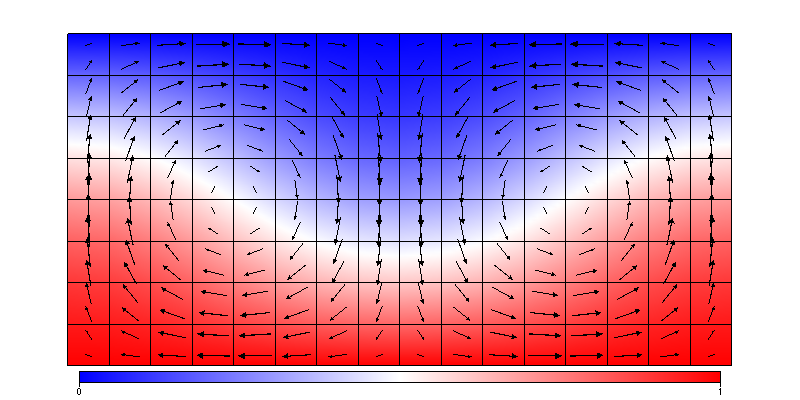

In [2]:
# Ready ?

solver0.solve()

# plot figure 

figtemp0 = glucifer.Figure( figsize=(800,400) )
figtemp0.append( glucifer.objects.Surface(mesh0, temperatureField0, colours="blue white red") )
figtemp0.append( glucifer.objects.VectorArrows(mesh0, velocityField0, arrowHead=0.2) )
figtemp0.append( glucifer.objects.Mesh(mesh0))
figtemp0.show()

print Ra

# (YES !)

In [6]:
def Vrms_fn(velocityField):
    int_vdotv_dV = uw.utils.Integral( fn.math.dot( velocityField, velocityField ), velocityField.mesh )
    int_1_dV     = uw.utils.Integral( 1.0 , velocityField.mesh )
    Vrms = int_vdotv_dV.evaluate()[0] / int_1_dV.evaluate()[0]

    return Vrms

def Nu_fn(temperatureField):
    
    nuNumerator    = uw.utils.Integral( fn=temperatureField.fn_gradient[1], 
                              mesh=temperatureField.mesh, integrationType='Surface', 
                              surfaceIndexSet=temperatureField.mesh.specialSets["MaxJ_VertexSet"])

    nuDenominator  = uw.utils.Integral( fn=temperatureField,               
                              mesh=temperatureField.mesh, integrationType='Surface', 
                              surfaceIndexSet=temperatureField.mesh.specialSets["MinJ_VertexSet"])

    Nusselt = -1.0 * nuNumerator.evaluate()[0] / nuDenominator.evaluate()[0]
    return Nusselt


In [8]:
glucifer_filename = "Ra-Resolutions"
store = glucifer.Store(filename=glucifer_filename)

frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh0, temperatureField0, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh0, velocityField0, arrowHead=0.2) )
frames.append( glucifer.objects.Mesh(mesh0))

In [11]:
## Take 500 timesteps on the coarses grid

time = 0.
step = 0
steps_end = 500

Nusselt_t = np.zeros(5000)
Vrms_t = np.zeros(5000)
times_t = np.zeros(5000)

    
step_1 = 0

while step_1 < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver0.solve()
    
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff0.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff0.integrate(dt)  ## <- The explicit timestep computations

    time += dt

    Nusselt_t[step] = Nu_fn(temperatureField0)
    Vrms_t[step] = Vrms_fn(velocityField0)
    times_t[step] = time

    if step%5 == 0:
        store.step=step
        frames.save()
        print("0: Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(step, times_t[step],
                                                                        Nusselt_t[step], Vrms_t[step] ))

    step += 1
    step_1 += 1
        
        

0: Step = 0 | time = 0.0 | Nusselt = 1.0 | Vrms = 1172.74922421
0: Step = 5 | time = 0.00452834341998 | Nusselt = 1.79095288816 | Vrms = 4039.09513783
0: Step = 10 | time = 0.00732313378786 | Nusselt = 3.00198342317 | Vrms = 6699.18114585
0: Step = 15 | time = 0.00986798815451 | Nusselt = 4.17492455094 | Vrms = 6441.28562852
0: Step = 20 | time = 0.0126518582534 | Nusselt = 4.87691552116 | Vrms = 4329.0577911
0: Step = 25 | time = 0.016101783739 | Nusselt = 4.95587442099 | Vrms = 2292.5251103
0: Step = 30 | time = 0.0206597974284 | Nusselt = 4.49936901277 | Vrms = 1135.36671808
0: Step = 35 | time = 0.026617535561 | Nusselt = 3.79975921967 | Vrms = 698.030987927
0: Step = 40 | time = 0.0334106259813 | Nusselt = 3.23724608894 | Vrms = 698.103274932
0: Step = 45 | time = 0.0397261272864 | Nusselt = 3.0044059365 | Vrms = 1034.5107038
0: Step = 50 | time = 0.0449391900033 | Nusselt = 3.06134499566 | Vrms = 1610.51283344
0: Step = 55 | time = 0.0493420476032 | Nusselt = 3.29290409292 | Vrms

0: Step = 475 | time = 0.424915346327 | Nusselt = 3.6651668285 | Vrms = 1801.08536959
0: Step = 480 | time = 0.429399874215 | Nusselt = 3.66516663513 | Vrms = 1801.08479477
0: Step = 485 | time = 0.433884402612 | Nusselt = 3.66516635553 | Vrms = 1801.08446904
0: Step = 490 | time = 0.438368931213 | Nusselt = 3.66516611019 | Vrms = 1801.08443577
0: Step = 495 | time = 0.442853459728 | Nusselt = 3.66516597399 | Vrms = 1801.08462531


**Plot final temperature and velocity field**


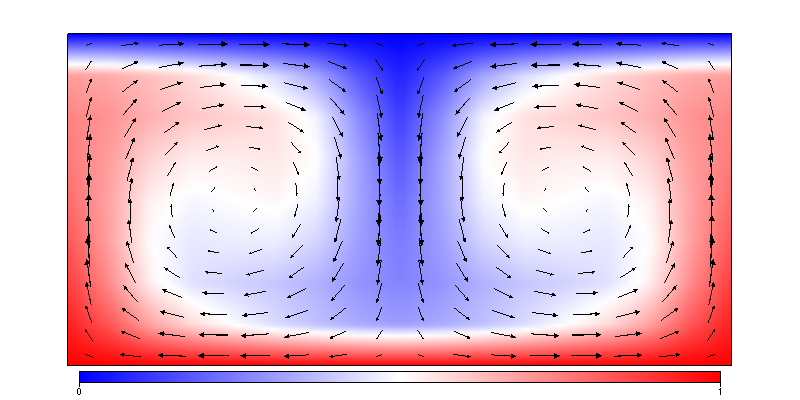

In [12]:
frames.show()

**Nusselt number**

The Nusselt number is the ratio between convective and conductive heat transfer. In the R-B convection example, that means 

\\[
Nu = -h \frac{ \int_0^l \partial_z T (x, z=h) dx}{ \int_0^l T (x, z=0) dx}
\\]


In [18]:
## Interpolate the temperature from Tmesh0, to Tmesh1

## We probably should re-set boundary conditions but it may not be necessary

temperatureField1.data[:] = temperatureField0.evaluate(mesh1) 

## Resolve

solver1.solve()



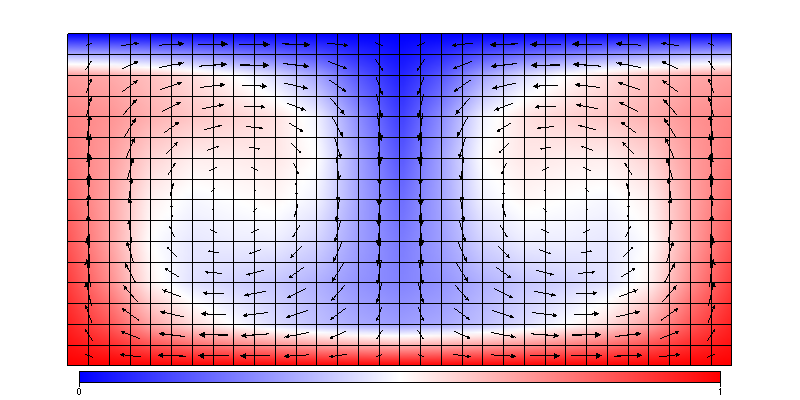

In [19]:
frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh1, temperatureField1, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh1, velocityField1, arrowHead=0.2) )
frames.append( glucifer.objects.Mesh(mesh1))
frames.show()

In [20]:
## Take 500 timesteps on the next grid
    
step_1 = 0

while step_1 < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver1.solve()
    
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff1.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff1.integrate(dt)  ## <- The explicit timestep computations

    time += dt

    Nusselt_t[step] = Nu_fn(temperatureField1)
    Vrms_t[step] = Vrms_fn(velocityField1)
    times_t[step] = time

    if step%5 == 0:
        store.step=step
        frames.save()
        print("0: Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(step, times_t[step],
                                                                        Nusselt_t[step], Vrms_t[step] ))

    step += 1
    step_1 += 1
        
        

0: Step = 500 | time = 0.446889464335 | Nusselt = 3.79125727746 | Vrms = 1857.53147732
0: Step = 505 | time = 0.449119221761 | Nusselt = 4.25037949056 | Vrms = 1895.23008231
0: Step = 510 | time = 0.451325897101 | Nusselt = 4.3821997793 | Vrms = 1924.83049233
0: Step = 515 | time = 0.45351619142 | Nusselt = 4.45680741381 | Vrms = 1940.97461621
0: Step = 520 | time = 0.455698670433 | Nusselt = 4.50425494787 | Vrms = 1943.02447469
0: Step = 525 | time = 0.457881716714 | Nusselt = 4.53472571591 | Vrms = 1931.81925547
0: Step = 530 | time = 0.460072478954 | Nusselt = 4.55277233728 | Vrms = 1909.99959366
0: Step = 535 | time = 0.462276223625 | Nusselt = 4.56027074032 | Vrms = 1881.54075144
0: Step = 540 | time = 0.464495919639 | Nusselt = 4.55834214605 | Vrms = 1850.95338918
0: Step = 545 | time = 0.466732079943 | Nusselt = 4.54848576068 | Vrms = 1822.42636549
0: Step = 550 | time = 0.468983002379 | Nusselt = 4.53285475057 | Vrms = 1799.13224799
0: Step = 555 | time = 0.47124541489 | Nussel

0: Step = 975 | time = 0.659875972905 | Nusselt = 4.48657184242 | Vrms = 1827.58162811
0: Step = 980 | time = 0.662120434739 | Nusselt = 4.48659117464 | Vrms = 1827.6070322
0: Step = 985 | time = 0.664364884444 | Nusselt = 4.48661267767 | Vrms = 1827.62522664
0: Step = 990 | time = 0.666609325951 | Nusselt = 4.48663377784 | Vrms = 1827.63535651
0: Step = 995 | time = 0.668853763478 | Nusselt = 4.48665232006 | Vrms = 1827.63753641



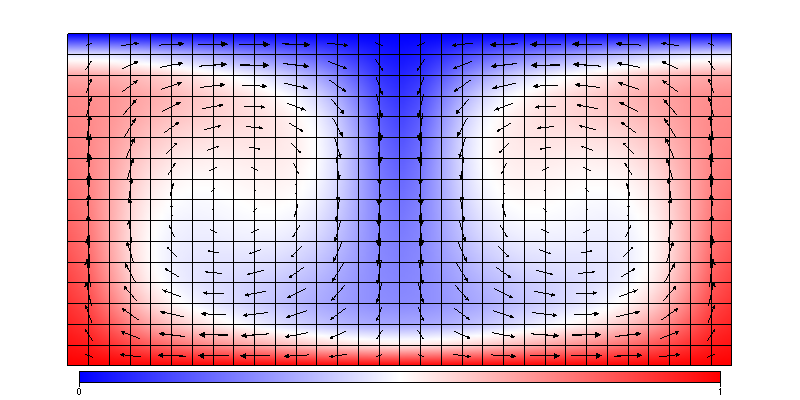

In [24]:
frames.show()

In [25]:
## Interpolate the temperature from Tmesh1, to Tmesh2

## We probably should re-set boundary conditions but it may not be necessary

temperatureField2.data[:] = temperatureField1.evaluate(mesh2) 

## Resolve

solver2.solve()



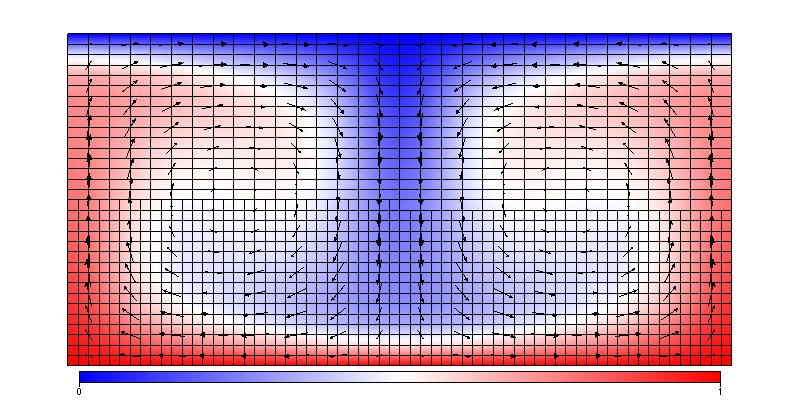

In [31]:
frames = glucifer.Figure(name="1", store=store, figsize=(800,400))
frames.append( glucifer.objects.Surface(Tmesh2, temperatureField2, colours="blue white red") )
frames.append( glucifer.objects.VectorArrows(mesh2, velocityField2, arrowHead=0.2) )
frames.append( glucifer.objects.Mesh(Tmesh2))
frames.show()

In [32]:
## Take 500 timesteps on the next grid
    
step_1 = 0

while step_1 < steps_end:
    # Solve for the velocity field given the current temperature field.
    solver2.solve()
    
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff2.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff2.integrate(dt)  ## <- The explicit timestep computations

    time += dt

    Nusselt_t[step] = Nu_fn(temperatureField2)
    Vrms_t[step] = Vrms_fn(velocityField2)
    times_t[step] = time

    if step%5 == 0:
        store.step=step
        frames.save()
        print("0: Step = {} | time = {} | Nusselt = {} | Vrms = {}".format(step, times_t[step],
                                                                        Nusselt_t[step], Vrms_t[step] ))

    step += 1
    step_1 += 1
        
        

0: Step = 1000 | time = 0.670874321276 | Nusselt = 4.56524501218 | Vrms = 1842.00100461
0: Step = 1005 | time = 0.671998439682 | Nusselt = 4.67980121935 | Vrms = 1847.25046636
0: Step = 1010 | time = 0.673120653242 | Nusselt = 4.71044043412 | Vrms = 1852.44516203
0: Step = 1015 | time = 0.67424110271 | Nusselt = 4.73260141937 | Vrms = 1856.94790648
0: Step = 1020 | time = 0.675360007778 | Nusselt = 4.74905341221 | Vrms = 1860.68009237
0: Step = 1025 | time = 0.676477651738 | Nusselt = 4.76150477476 | Vrms = 1863.53696691
0: Step = 1030 | time = 0.677594359791 | Nusselt = 4.77104589358 | Vrms = 1865.42387843
0: Step = 1035 | time = 0.678710476053 | Nusselt = 4.77841827676 | Vrms = 1866.28093
0: Step = 1040 | time = 0.679826344565 | Nusselt = 4.78415703675 | Vrms = 1866.09599341
0: Step = 1045 | time = 0.680942294534 | Nusselt = 4.78865324329 | Vrms = 1864.9083368
0: Step = 1050 | time = 0.682058628433 | Nusselt = 4.79217659078 | Vrms = 1862.80569458
0: Step = 1055 | time = 0.68317561181

0: Step = 1470 | time = 0.776538558957 | Nusselt = 4.7773511425 | Vrms = 1834.81468558
0: Step = 1475 | time = 0.77766341326 | Nusselt = 4.77722602214 | Vrms = 1834.67911143
0: Step = 1480 | time = 0.778788302564 | Nusselt = 4.77709379035 | Vrms = 1834.5634236
0: Step = 1485 | time = 0.779913221654 | Nusselt = 4.77695870267 | Vrms = 1834.46931895
0: Step = 1490 | time = 0.781038164886 | Nusselt = 4.77682476804 | Vrms = 1834.39775549
0: Step = 1495 | time = 0.782163126378 | Nusselt = 4.77669565378 | Vrms = 1834.34898433



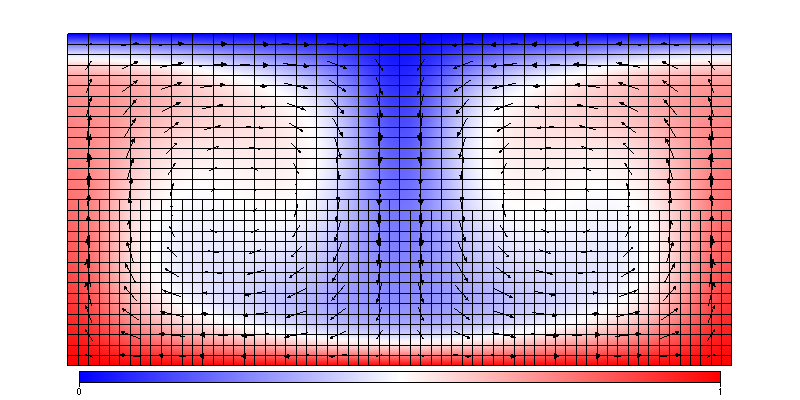

In [33]:
frames.show()

In [34]:
view = glucifer.lavavu.Viewer(database="{}.gldb".format(glucifer_filename))
# print(view.steps)

view.control.Panel()
view.control.Checkbox(property='axis')
view.control.ObjectList()
view.control.TimeStepper()
view.control.show()

<IPython.core.display.Javascript object>

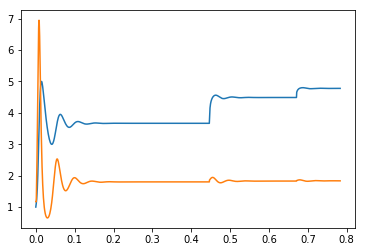

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [36]:
## Make a plot of Nu / Vrms against time

%matplotlib inline

from matplotlib import pyplot as plt

graph = plt.Figure(figsize=(10,5))
ax = plt.subplot(111)
# ax.set_ylim(3.8,4.4)
ax.plot(times_t[0:1500], Nusselt_t[0:1500])
ax.plot(times_t[0:1500], Vrms_t[0:1500]*0.001)




In [ ]:
print("Nusselt_no at final state - {}".format(Nusselt_t[-1]))
print("Vrms at final state - {}".format(Vrms_t[-1]))